# US Flight Disruption: 2015
### by Stephani Marcelli Djojo (June 2020)

## Investigation Overview
This document tells exploration result of a dataset of **2015 flight delays and cancellations** which was published by the U.S. Department of Transportation's Bureau of Transportation Statistics (source: <a href='https://www.kaggle.com/usdot/flight-delays'>Kaggle</a>). This documment figures out what are the best and worst airlines in terms of flight disruption handling.

## Dataset Overview
There are 5,819,079 observations in the dataset with 19 variables. Most variables are categorical data, while numeric data are exist on these three valiable groups: distance, scheduled flight duration, and delay duration.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import time
import math
import re

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
df_flight = pd.read_csv('../data/flight_delays/flights.csv')

# remove some columns from dataset which aren't used in this exploration
remove_cols = [
    'YEAR',
    'FLIGHT_NUMBER','TAIL_NUMBER',
    'SCHEDULED_DEPARTURE','DEPARTURE_TIME','DEPARTURE_DELAY',
    'TAXI_OUT','WHEELS_OFF','ELAPSED_TIME','AIR_TIME',
    'WHEELS_ON','TAXI_IN','SCHEDULED_ARRIVAL','ARRIVAL_TIME','ARRIVAL_DELAY'
]
df_flight = df_flight.drop(remove_cols, axis=1)

In [3]:
# copy original dataset
df_flight_raw = df_flight.copy()

# convert datatype DIVERTED and CANCELLED from integer to boolean
df_flight_raw['DIVERTED'] = df_flight_raw['DIVERTED'].apply(lambda x: bool(x))
df_flight_raw['CANCELLED'] = df_flight_raw['CANCELLED'].apply(lambda x: bool(x))

# create DELAYED column
idx = df_flight_raw.query('AIR_SYSTEM_DELAY>0 | SECURITY_DELAY>0 | AIRLINE_DELAY>0 | LATE_AIRCRAFT_DELAY>0 | WEATHER_DELAY>0').index
df_flight_raw['DELAYED']=False
df_flight_raw.loc[idx,'DELAYED']=True

# create DELAY_TIME column
df_flight_raw['DELAY_TIME']=df_flight_raw['AIR_SYSTEM_DELAY']\
                            +df_flight_raw['AIRLINE_DELAY']\
                            +df_flight_raw['LATE_AIRCRAFT_DELAY']\
                            +df_flight_raw['SECURITY_DELAY']\
                            +df_flight_raw['WEATHER_DELAY']

# create DEPARTURE_DATE column
df_flight_raw['DEPARTURE_DATE'] = pd.to_datetime((2015*10000\
                                              +df_flight_raw['MONTH']*100\
                                              +df_flight_raw['DAY']).apply(str),format='%Y%m%d')

# map CANCELLATION_REASON value
def map_cancel_reason(code):
    if code=='A': return "Airline/Carrier"
    elif code=='B': return "Weather"
    elif code=='C': return "National Air System"
    elif code=='D': return "Security"
    else: return code

df_flight_raw['CANCELLATION_REASON'] = df_flight_raw['CANCELLATION_REASON']\
                                            .apply(lambda x: map_cancel_reason(x))

In [4]:
# create summary dataset df_flight_agg
groupby_cols = ['DEPARTURE_DATE','MONTH','DAY','DAY_OF_WEEK','AIRLINE']
tmp_df1 = df_flight_raw.groupby(groupby_cols, as_index=False)[['ORIGIN_AIRPORT']].count()
tmp_df1.rename(columns={'ORIGIN_AIRPORT':'NUM_FLIGHT'}, inplace=True)

sum_cols = ['DELAYED','CANCELLED','DIVERTED','DELAY_TIME','SCHEDULED_TIME','DISTANCE']
tmp_df2 = df_flight_raw.groupby(groupby_cols, as_index=False)[sum_cols].sum()
tmp_df2.rename(columns={'DELAYED':'NUM_DELAY_FLIGHT',
                        'CANCELLED':'NUM_CANCEL_FLIGHT',
                        'DIVERTED':'NUM_DIVERT_FLIGHT',
                        'DELAY_TIME':'SUM_DELAY_TIME',
                        'SCHEDULED_TIME':'SUM_SCHEDULED_TIME',
                        'DISTANCE':'SUM_DISTANCE'}, inplace=True)

tmp_df3 = df_flight_raw.groupby(groupby_cols, as_index=False)[['DELAY_TIME','SCHEDULED_TIME','DISTANCE']].mean()
tmp_df3.rename(columns={'DELAY_TIME':'AVG_DELAY_TIME',
                        'SCHEDULED_TIME':'AVG_SCHEDULED_TIME',
                        'DISTANCE':'AVG_DISTANCE'}, inplace=True)

df_flight_agg = (tmp_df1.merge(tmp_df2, how='inner', on=groupby_cols)).merge(tmp_df3, how='inner', on=groupby_cols)
df_flight_agg['NUM_DISRUPTED_FLIGHT'] = (df_flight_agg['NUM_DELAY_FLIGHT']
                                        +df_flight_agg['NUM_CANCEL_FLIGHT']
                                        +df_flight_agg['NUM_DIVERT_FLIGHT'])
df_flight_agg['DISRUPTION_RATE'] = df_flight_agg['NUM_DISRUPTED_FLIGHT']/df_flight_agg['NUM_FLIGHT']

> Note that the above cells have been set as "Skip"-type slides. That means
that when the notebook is rendered as http slides, those cells won't show up.

## 16.7% of US flights in 2015 were disrupted. 
Most cases were due to delayed flight. NK is the airline which has the highest disruption rate (relative to NK's flights), while HA is the airline which has the lowest disruption rate.

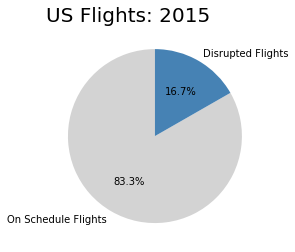

In [5]:
sizes = [df_flight_raw.shape[0],df_flight_raw.query('DELAYED==True | CANCELLED==True | DIVERTED==True').shape[0]]
labels = ['On Schedule Flights','Disrupted Flights']

plt.figure();
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['lightgray','steelblue']);
plt.title("US Flights: 2015", loc='left', fontsize=20, fontweight=0, color='black');

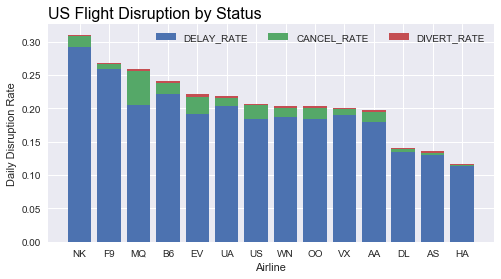

In [6]:
df_flight_agg_airline = df_flight_agg.groupby('AIRLINE', as_index=False)\
                        [['NUM_DELAY_FLIGHT','NUM_CANCEL_FLIGHT','NUM_DIVERT_FLIGHT','NUM_DISRUPTED_FLIGHT','NUM_FLIGHT']]\
                        .sum()

df_flight_agg_airline['DELAY_RATE'] = df_flight_agg_airline['NUM_DELAY_FLIGHT']*1.0/df_flight_agg_airline['NUM_FLIGHT']
df_flight_agg_airline['CANCEL_RATE'] = df_flight_agg_airline['NUM_CANCEL_FLIGHT']*1.0/df_flight_agg_airline['NUM_FLIGHT']
df_flight_agg_airline['DIVERT_RATE'] = df_flight_agg_airline['NUM_DIVERT_FLIGHT']*1.0/df_flight_agg_airline['NUM_FLIGHT']
df_flight_agg_airline['DISRUPTION_RATE'] = df_flight_agg_airline['NUM_DISRUPTED_FLIGHT']*1.0/df_flight_agg_airline['NUM_FLIGHT']


plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=[8,4])

cols = ['DELAY_RATE','CANCEL_RATE','DIVERT_RATE']
data = df_flight_agg_airline.sort_values(by='DISRUPTION_RATE', ascending=False)
bottom = 0
for i in range(len(cols)):
    ax.bar(x=data['AIRLINE'], height=data[cols[i]], bottom=bottom, label=cols[i]);
    bottom = bottom+data[cols[i]]
    
ax.legend(loc=1, ncol=3);
ax.set_xlabel('Airline');
ax.set_ylabel('Daily Disruption Rate');
ax.set_title("US Flight Disruption by Status", loc='left', fontsize=16, fontweight=0, color='black');

## Relationship features with airline's daily disruption rate
Airline's daily average delay time and daily number of disrupted flights have positive moderate correlation to airline's daily disruption rate with pearson correlation 0.513 and 0.447.

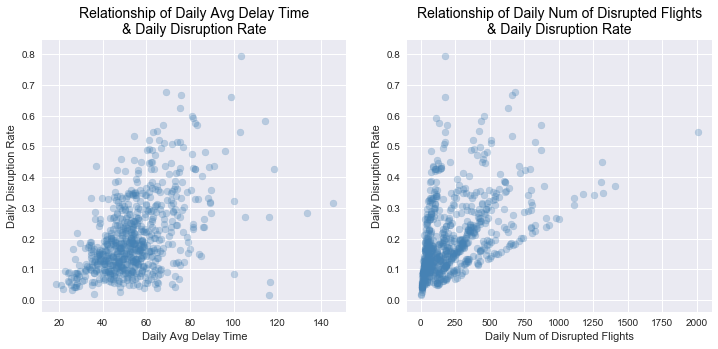

In [7]:
corr_cols = ['AVG_DELAY_TIME','NUM_DISRUPTED_FLIGHT']
xlabels = ['Daily Avg Delay Time','Daily Num of Disrupted Flights']
titles = ['Relationship of Daily Avg Delay Time\n& Daily Disruption Rate',
          'Relationship of Daily Num of Disrupted Flights\n& Daily Disruption Rate']

samples = np.random.choice(df_flight_agg.shape[0], 700, replace = False)
df_flight_samp = df_flight_agg.loc[samples,:]

plt.style.use('seaborn')
fig, ax = plt.subplots(ncols=len(corr_cols),figsize=[12,5])
for i in range(len(corr_cols)):
    ax[i].scatter(x=df_flight_samp[corr_cols[i]], y=df_flight_samp['DISRUPTION_RATE'], color='steelblue', alpha='0.3');
    ax[i].set_xlabel(xlabels[i]);
    ax[i].set_ylabel('Daily Disruption Rate');   
    ax[i].set_title(titles[i], loc='center', fontsize=14, fontweight=0, color='black');   

## Disrupted Flights and Disruption Rate Relationship by Airlines
Daily disrupted flights and daily disruption rate showed strong positive correlation if we see it per airline.
When we see their relationship in overall airlines, those features have moderate correlation (corr = 0.447). After we breaked it down by airline, we will found those features have strong correlation (corr = 0.9). It is caused each airline has different slope of linear relationship.

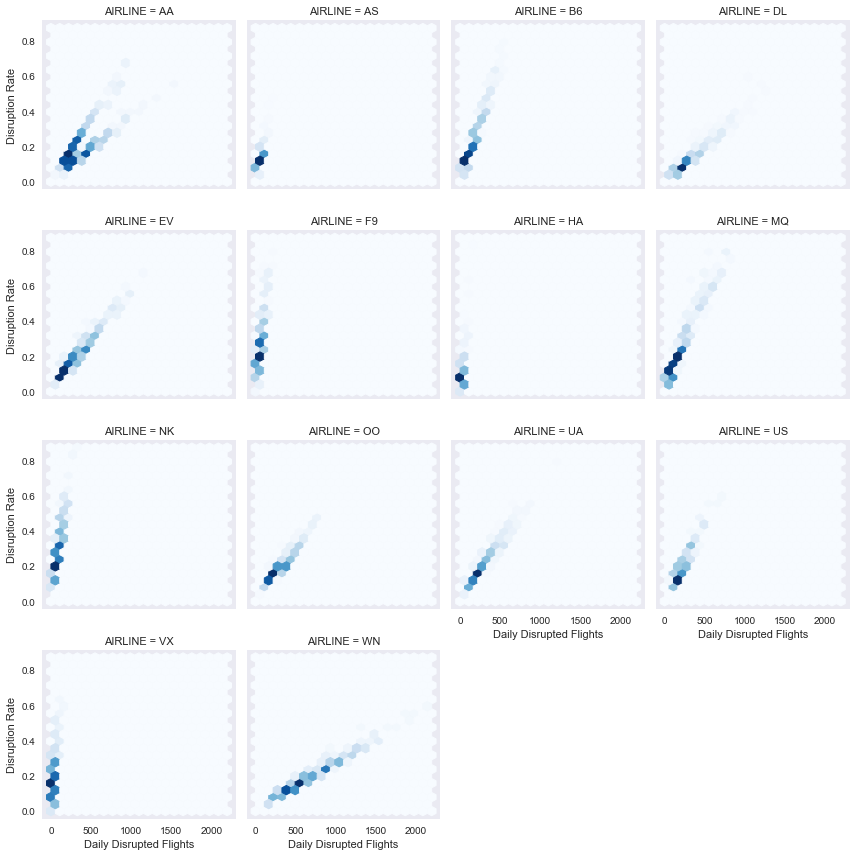

In [8]:
def hexbingrid(x,y, color, **kwargs):
    plt.hexbin(x, y, gridsize=20, cmap='Blues', **kwargs)
    
x = df_flight_agg.NUM_DISRUPTED_FLIGHT
y = df_flight_agg.DISRUPTION_RATE
xmin = x.min()
xmax = x.max()
ymin = y.min()
ymax = y.max()

with sns.axes_style("dark"):
    g = sns.FacetGrid(data=df_flight_agg, col='AIRLINE', col_wrap=4,height=3);
g.map(hexbingrid, 'NUM_DISRUPTED_FLIGHT', 'DISRUPTION_RATE', extent=[xmin, xmax, ymin, ymax]);

g.set_xlabels('Daily Disrupted Flights');
g.set_ylabels('Disruption Rate');

# Which are the best and the worst airlines in 2015?

HA, AS, and VN are the best airlines in 2015 in terms of flight disruption handling. They have disruption rate and average delay time lower than median - see quadrant 1 (buttom left) in next slide. While, NK, F9, MQ, UA, and EV are the worse airlines in 2015 in terms of flight disruption handling.

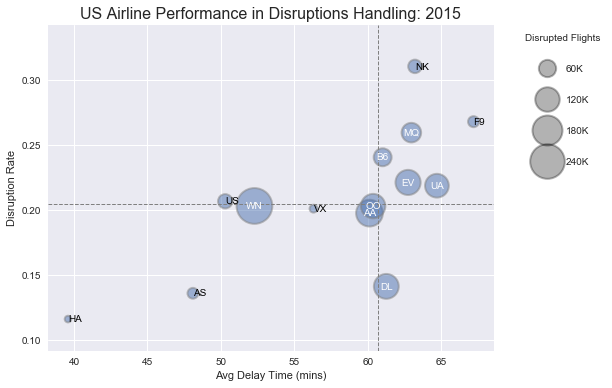

In [9]:
df_flight_agg_airline = df_flight_agg.groupby('AIRLINE', as_index=False)[['NUM_FLIGHT','NUM_DELAY_FLIGHT','NUM_DISRUPTED_FLIGHT','SUM_DELAY_TIME']].sum()
df_flight_agg_airline['DISRUPTION_RATE'] = df_flight_agg_airline['NUM_DISRUPTED_FLIGHT']*1.0/df_flight_agg_airline['NUM_FLIGHT']
df_flight_agg_airline['AVG_DELAY_TIME'] = df_flight_agg_airline['SUM_DELAY_TIME']*1.0/df_flight_agg_airline['NUM_DELAY_FLIGHT']

fig, ax = plt.subplots(figsize=[8,6]);
x = df_flight_agg_airline['AVG_DELAY_TIME']
y = df_flight_agg_airline['DISRUPTION_RATE']
z = df_flight_agg_airline['NUM_DISRUPTED_FLIGHT']
label = df_flight_agg_airline['AIRLINE']

scatter = ax.scatter(x, y, s=z*0.005, alpha=0.5, edgecolors="gray", linewidth=2);

ax.set_xlabel("Avg Delay Time (mins)");
ax.set_ylabel("Disruption Rate");
ax.set_title("US Airline Performance in Disruptions Handling: 2015", fontsize=16);
ax.axhline(df_flight_agg_airline['DISRUPTION_RATE'].median(), 
           color='gray', linestyle='dashed', linewidth=1, label='Median Disruption Rate')
ax.axvline(df_flight_agg_airline['AVG_DELAY_TIME'].median(), 
           color='gray', linestyle='dashed', linewidth=1, label='Median Avg Delay Time')

#For each point, we add a text inside the bubble
for line in range(0,df_flight_agg_airline.shape[0]):
    if z[line]<60000: 
        color='black' 
        horizontalalignment='left'
    else: 
        color='white'
        horizontalalignment='center'
    
    ax.text(x[line], y[line], label[line], 
             verticalalignment='center', horizontalalignment=horizontalalignment, size='medium', color=color)

handles, labels = scatter.legend_elements(prop='sizes', alpha=0.3, num=4)
labels1 = ["{}K".format(int(int(re.search("\d+", x)[0])/0.005/1000)) for x in labels]
legend = ax.legend(handles, labels1, loc="upper left", title='Disrupted Flights', labelspacing=2.2, bbox_to_anchor=(1.05, 1.0))